In [1]:
import kornia as k
import kornia.color as ko
import kornia.enhance as ke
import kornia.morphology as km

from methods import Colors_Descriptors as CD

import os
import PIL 
from pathlib import Path
from typing import List

from PIL.Image import Image
from PIL import Image as Im

import cv2
import torch
import copy

import numpy as np


import matplotlib.pyplot as plt

In [2]:
from utils import utils

In [19]:
#permute = lambda x: x.permute(1,2,0)
def non_max_suppression(predictions: np.ndarray, iou_threshold: float = 0.5) -> np.ndarray:
    
    rows, columns = predictions.shape

    sort_index = np.flip(predictions[:, 4].argsort())
    predictions = predictions[sort_index]

    boxes = predictions[:, :4]
    categories = predictions[:, 5]
    ious = box_iou_batch(boxes, boxes)
    ious = ious - np.eye(rows)

    keep = np.ones(rows, dtype=bool)

    for index, (iou, category) in enumerate(zip(ious, categories)):
        if not keep[index]:
            continue

        condition = (iou > iou_threshold) & (categories == category)
        keep = keep & ~condition

    return keep[sort_index.argsort()]


def permute(img):
    if isinstance(img, np.ndarray):
        return np.transpose(img, (1,2,0))
    else:
        return img.permute(1,2,0).numpy()

def show_image(image):
    cv2.imshow("image", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()   
    
    
def apply_top_hat(image, kernel):
    if isinstance(kernel, tuple):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,  
                                   kernel)
        
    top_hat = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)
    return top_hat

def apply_black_hat(image, kernel):
    if isinstance(kernel, tuple):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,  
                                   kernel)
        
    top_hat = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, kernel)
    return top_hat


def apply_closing(image, kernel):
    if isinstance(kernel, tuple):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,  
                                   kernel)
        
    closing = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return closing

def apply_open(image, kernel, iters:int=3):
    if isinstance(kernel, tuple):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,  
                                   kernel)
        
        
    op = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iters)
    return op

def apply_dilate(image, kernel, iterations:int=5):
    
    if isinstance(kernel, tuple):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,  
                                   kernel)
        
        
    op = cv2.dilate(image, kernel, iterations = iterations)
    return op

def apply_erode(image, kernel):
    
    if isinstance(kernel, tuple):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,  
                                   kernel)
        
        
    op = cv2.erode(image, kernel)
    return op

def apply_morpholical_grad(image, kernel):
    if isinstance(kernel, tuple):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,  
                                   kernel)
        
        
    op = cv2.morphologyEx(image, cv2.MORPH_GRADIENT, kernel)
    return op


def normalize(img, m=0., mx=1.):
    return cv2.normalize(img, None, m, mx, cv2.NORM_MINMAX, dtype=cv2.CV_32F)


def sharpening(img):
    kernel = np.array([[0, -1, 0],
                        [-1, 10, -1],
                        [0, -1, 0]])
    sharpened = cv2.filter2D(img, -1, kernel)
    
    return sharpened

def apply_Canny(img):
    pass



def extract_paintings(imgs: List[np.ndarray]):
    
    """
    We assume that the image is in CieLab or CieLuv
    """
    response = {idx:[] for idx in range(len(imgs))}
    for idx, img in enumerate(imgs):
        morph = apply_morpholical_grad(img, (7,7))
        luminance = (morph[:,:,0]*255).astype(np.uint8)
        thresholded = cv2.adaptiveThreshold(closed, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 3, 3)
        final_image = apply_closing(im, (3,3))
        final_image = apply_dilate(final_image, (3,3))
        
        decission = get_roi_paintings(final_image)
        
        for dec in decission:
            x,y,w,h = dec[0]
            cropped = final_image[y:y+h, x:x+w,:]
            response[idx].append(cropped)
            
    return response

def conver2image(img:np.ndarray):
    return (img*255).astype(np.uint8)

## Esta es la funció de preprocesado, hay algo aqui que si se cambia o se añade deberia ir bién seguro pero no sé el qué
## Aprovecho el HSV pero queria probar mezclar la L del (LAB o LUV) y la S de la saturación para opacar el color del fondo


## BBox Detection (Aquí está lo que he hecho)

In [4]:
def preproces_detect_bbox(image):

    # Prepare colorspaces
    print(image.shape)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(lab)
    l = normalize(l)

    image = l-s
    # Apply morphology
    morph_open = 1 - normalize(apply_closing(image, (20,20)))#1 - normalize(apply_dilate(image, (10,10)))
    mean = (np.mean(morph_open))
    std = (np.std(morph_open)) 
    ret, th1 = cv2.threshold(morph_open, np.min(morph_open)+((mean-std)*0.5),  255, cv2.THRESH_BINARY_INV)

    th2 = apply_dilate(th1, (12,1))

    
    return th2

def detect_bbox(image):
    ## Después del preproces la zona que tiene el texto esta oscurecido (por la saturación)
    ## así que  lo que quiero es coger la zona con una media más baja (más negro) para aplica el threshold
    ## Asumiendo que esa zona es muy negra (( errores ... imagenes con un fondo oscuro o muy saturado))
    
    th1 = preproces_detect_bbox(image)
    plt.imshow(th1)
    contours, hierarchy = cv2.findContours(conver2image(th1), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    decission = []
    prop_low = 2*th1.shape[0]//5
    prop_upper = 4*th1.shape[0]//5
    for contour in contours:
        convexHull = cv2.convexHull(contour)
        
        x,y,w,h = cv2.boundingRect(convexHull)
        aspect_ratio = w/h
        area = w*h
        min_length  = w > th1.shape[1]*0.1
        relation_ar = np.sqrt(aspect_ratio)
        perimeter = cv2.arcLength(convexHull, True)
            
            
        if (h <= prop_low or (h >= prop_upper)) and ((relation_ar > 1) and (relation_ar < 6)) and (1.5*w>h) and (min_length): 
            decission.append(([y,x,h,w], area, perimeter ,aspect_ratio)) 

            
    decission = sorted(decission, key=lambda x: x[2], reverse=True)
            
            
    return decission 


def filter_and_reduce_bounding_boxes(bboxes, shape_mask):
    
    constrain_bbox = []
    processed_indexes = set()
    oh, ow = shape_mask
    for i in range(len(bboxes)):
        if i in processed_indexes:
            continue
            
        bbox1 = bboxes[i][0]
        y1, x1, h1, w1 = bbox1
        rec_ver1 = w1 > h1
        
        for j in range(i+1, len(bboxes)):
            if j in processed_indexes:
                continue
                
            y2,x2,h2,w2 = bboxes[j][0]
            y_overlap = abs(y1 - y2)
            rec_ver2 = w2 > h2
            
            if (y_overlap <= (oh*0.05)) and (rec_ver1 and rec_ver2):
                y, x = min([y1,x1], [y2, x2], key=lambda x: x[1])
                w = w1 + w2
                h = max(h1, h2)
                area = w*h
                try:
                    aspect_ratio = w/h
                except:
                    aspect_ratio = 0
                constrain_bbox.append(([y,x,h,w], area, aspect_ratio))
                
                processed_indexes.add(j)        
                
    return constrain_bbox

def detect_text(image:np.ndarray):
    mask = np.zeros((im.shape[:2]))
    bbox = detect_bbox(im)
    print(bbox)
    

def create_bbox_masks(images: List[Image]):
    result = {image.name:{} for image in images}
    
    for idx, image in enumerate(images):
        im = permute(utils.read_img(image))
        mask = np.zeros((im.shape[:2]))

        bboxes = detect_bbox(im)
        #print(bboxes)
        if len(bboxes) == 1:
            y,x,h,w = bboxes[0][0]

        else:
            reduction = filter_and_reduce_bounding_boxes(bboxes, mask.shape)
            tmp = reduction
            print(tmp)
            while (len(reduction)) != 0:
                reduction = filter_and_reduce_bounding_boxes(tmp, mask.shape)
                print(reduction)
                if len(reduction) != 0:
                    tmp = reduction

            else:
                if len(tmp) == 0:
                    tmp = bboxes

            print(tmp, image.name)

            bboxes = sorted(tmp, key=lambda x: x[2], reverse=True)[0]  
            y, x, h, w = bboxes[0]

        # [[tlx1, tly1, brx1, bry1],[tlx2, tly2, brx2, bry2]]

        mask[y:y+h, x:x+w] = 1
        result[image.name]["mask"] = mask
        result[image.name]["bbox"] = [[x,y, x+w, y+h]]
        #plt.imshow(mask, cmap="gray")

    return result
            
                
            
                
            
            
            
 

In [5]:
def iou_metric(y_true: np.array, y_preds: np.array, epsilon=1e-6):
    
    intersection = ((y_preds == 1) & (y_true == 1)).sum()
    union = ((y_preds == 1) | (y_true == 1)).sum()
    
    iou = (intersection + epsilon) / (union + epsilon)
    
    return iou

def conver_to_bbox(array):
    x = array[0][0] # 101
    y = array[0][1] # 6

    h = array[2][1] -  y
    w = array[2][0] - x
    return y, x, h, w

In [2555]:
BBDD =  sorted(utils.read_bbdd(Path("../data/qsd1_w2")))
print(BBDD)

[PosixPath('../data/qsd1_w2/00000.jpg'), PosixPath('../data/qsd1_w2/00001.jpg'), PosixPath('../data/qsd1_w2/00002.jpg'), PosixPath('../data/qsd1_w2/00003.jpg'), PosixPath('../data/qsd1_w2/00004.jpg'), PosixPath('../data/qsd1_w2/00005.jpg'), PosixPath('../data/qsd1_w2/00006.jpg'), PosixPath('../data/qsd1_w2/00007.jpg'), PosixPath('../data/qsd1_w2/00008.jpg'), PosixPath('../data/qsd1_w2/00009.jpg'), PosixPath('../data/qsd1_w2/00010.jpg'), PosixPath('../data/qsd1_w2/00011.jpg'), PosixPath('../data/qsd1_w2/00012.jpg'), PosixPath('../data/qsd1_w2/00013.jpg'), PosixPath('../data/qsd1_w2/00014.jpg'), PosixPath('../data/qsd1_w2/00015.jpg'), PosixPath('../data/qsd1_w2/00016.jpg'), PosixPath('../data/qsd1_w2/00017.jpg'), PosixPath('../data/qsd1_w2/00018.jpg'), PosixPath('../data/qsd1_w2/00019.jpg'), PosixPath('../data/qsd1_w2/00020.jpg'), PosixPath('../data/qsd1_w2/00021.jpg'), PosixPath('../data/qsd1_w2/00022.jpg'), PosixPath('../data/qsd1_w2/00023.jpg'), PosixPath('../data/qsd1_w2/00024.jpg'),

[([21, 103, 58, 454], 26332, 7.827586206896552)]
[]
[([21, 103, 58, 454], 26332, 7.827586206896552)] 00000.jpg
[([197, 362, 21, 116], 2436, 5.523809523809524), ([305, 248, 3, 116], 348, 38.666666666666664)]
[]
[([197, 362, 21, 116], 2436, 5.523809523809524), ([305, 248, 3, 116], 348, 38.666666666666664)] 00001.jpg
[([132, 587, 66, 558], 36828, 8.454545454545455)]
[]
[([132, 587, 66, 558], 36828, 8.454545454545455)] 00003.jpg
[([68, 143, 121, 312], 37752, 2.5785123966942147)]
[]
[([68, 143, 121, 312], 37752, 2.5785123966942147)] 00004.jpg
[]
[([350, 29, 22, 244], 5368, 508.3857704401016, 11.090909090909092), ([114, 232, 50, 57], 2850, 208.04296112060547, 1.14), ([219, 232, 7, 56], 392, 122.0, 8.0)] 00008.jpg
[]
[([276, 25, 22, 212], 4664, 448.25126791000366, 9.636363636363637), ([318, 78, 5, 155], 775, 315.0051040649414, 31.0)] 00009.jpg
[]
[([520, 88, 24, 507], 12168, 1049.2762985229492, 21.125), ([116, 258, 13, 111], 1443, 234.64126110076904, 8.538461538461538)] 00010.jpg
[([29, 9, 21

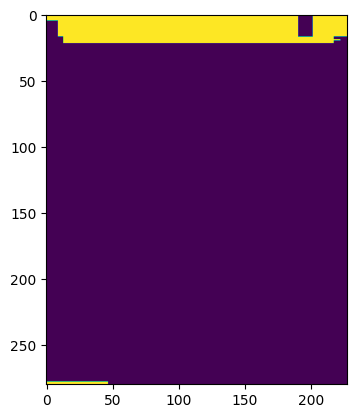

In [2503]:
masks = create_bbox_masks(BBDD)

In [2562]:
ground_truth_text_box = (utils.read_pickle("../data/qsd1_w2/text_boxes.pkl"))

gt = []
iou = []
for i ,(g, idx) in enumerate(zip(ground_truth_text_box, masks.keys())):
    tmp = masks[idx]
    mask = tmp["mask"]
    
    tmp_mask = np.zeros_like(mask)

    y, x, h, w = conver_to_bbox(g[0])
    
    tmp_mask[y:y+h, x:x+w] = 1
    
    iou.append(iou_metric(tmp_mask, mask))
    
    

0.4997392760614509


In [2522]:
print(masks)

{'00000.jpg': {'mask': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'bbox': [[103, 21, 557, 79]]}, '00001.jpg': {'mask': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'bbox': [[248, 305, 364, 308]]}, '00002.jpg': {'mask': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'bbox': [[482, 1798, 1138, 1884]]}, '00003.jpg': {'mask': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0

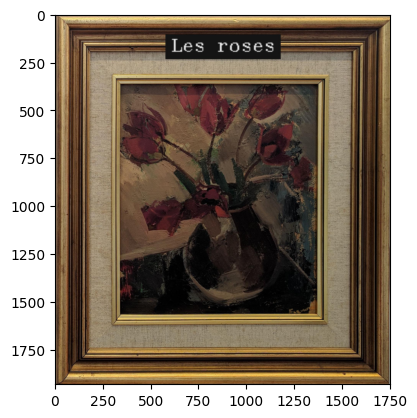

In [2474]:
plt.imshow(img_test)

0.775
True
False
False
True
True
False
0.08157894736842106
True
False
False
True
False
False
0.15625
True
False
False
True
False
False
57.0
True
False
True
False
True
False
56.0
True
False
True
False
True
False
0.07216494845360824
True
False
False
True
False
False
56.0
True
False
True
False
True
False
7.461538461538462
True
False
True
True
True
False
57.0
True
False
True
False
True
False
56.0
True
False
True
False
True
False
7.25
True
False
True
True
True
False
7.276595744680851
True
False
True
True
True
False
3.272727272727273
True
False
True
True
True
False
28.0
True
False
True
False
True
False
30.0
True
False
True
False
True
False
28.5
True
False
True
False
True
False
194.66666666666666
True
False
True
False
True
True


[]

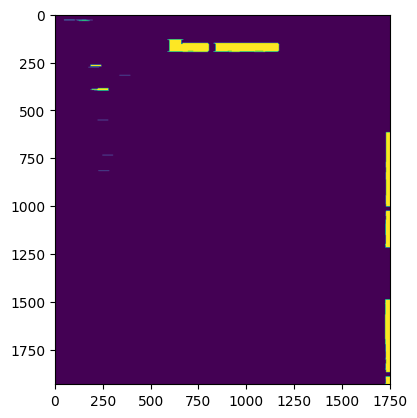

In [2475]:
detect_bbox(img_test)

In [2481]:
print(masks)

{'00000.jpg': {'mask': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'bbox': [[103, 21, 557, 79]]}, '00001.jpg': {'mask': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'bbox': [[248, 305, 364, 308]]}, '00002.jpg': {'mask': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'bbox': [[482, 1798, 1138, 1884]]}, '00003.jpg': {'mask': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0

In [2501]:
response_final = []

In [2433]:
for idx, (name, array) in enumerate(masks.items()):
    new_name = name.split(".")[0]+".png"
    Im.fromarray(conver2image(array["mask"])).save(new_name)
    response_final.append(array["bbox"])
    
print(response_final)



[[[60, 338, 448, 369]], [[27, 378, 275, 400]], [[37, 315, 379, 356]], [[12, 0, 232, 25]], [[41, 0, 400, 61]], [[66, 324, 450, 358]], [[59, 58, 439, 93]], [[663, 116, 1279, 169]], [[16, 13, 258, 51]], [[25, 272, 310, 318]], [[95, 587, 707, 674]], [[566, 1634, 1189, 1696]], [[40, 310, 326, 339]], [[33, 25, 354, 62]], [[42, 17, 341, 39]], [[23, 0, 298, 51]], [[32, 38, 345, 79]], [[84, 418, 538, 450]], [[7, 13, 211, 57]], [[140, 704, 743, 760]], [[552, 1341, 1207, 1427]], [[134, 0, 343, 48]], [[40, 20, 340, 52]], [[0, 0, 256, 28]], [[535, 2086, 1190, 2188]], [[79, 491, 519, 538]], [[8, 18, 203, 46]], [[485, 1929, 1109, 1993]], [[52, 31, 464, 108]], [[61, 550, 429, 594]]]


In [2563]:
utils.write_pickle(masks, filepath="../data/BBDD/descriptors/result_bbox_query.pkl")

In [2435]:
utils.read_pickle("./result_bbox.pkl")

[[[60, 338, 448, 369]],
 [[27, 378, 275, 400]],
 [[37, 315, 379, 356]],
 [[12, 0, 232, 25]],
 [[41, 0, 400, 61]],
 [[66, 324, 450, 358]],
 [[59, 58, 439, 93]],
 [[663, 116, 1279, 169]],
 [[16, 13, 258, 51]],
 [[25, 272, 310, 318]],
 [[95, 587, 707, 674]],
 [[566, 1634, 1189, 1696]],
 [[40, 310, 326, 339]],
 [[33, 25, 354, 62]],
 [[42, 17, 341, 39]],
 [[23, 0, 298, 51]],
 [[32, 38, 345, 79]],
 [[84, 418, 538, 450]],
 [[7, 13, 211, 57]],
 [[140, 704, 743, 760]],
 [[552, 1341, 1207, 1427]],
 [[134, 0, 343, 48]],
 [[40, 20, 340, 52]],
 [[0, 0, 256, 28]],
 [[535, 2086, 1190, 2188]],
 [[79, 491, 519, 538]],
 [[8, 18, 203, 46]],
 [[485, 1929, 1109, 1993]],
 [[52, 31, 464, 108]],
 [[61, 550, 429, 594]]]

In [2504]:
m = list(masks.values())


In [2517]:
idd = 3



In [2518]:
img_test = permute(utils.read_img(BBDD[idd]))
img_test.shape

(1932, 1752, 3)

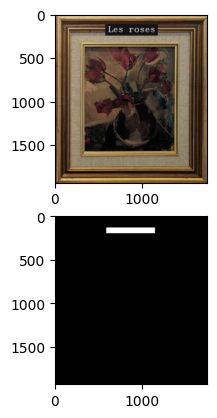

In [2519]:
f, axarr = plt.subplots(2,1)
axarr[0].imshow(img_test)
axarr[1].imshow(m[idd]["mask"], cmap="gray")


[([23, 30, 34, 309], 10506, 682.0, 9.088235294117647)]


[]

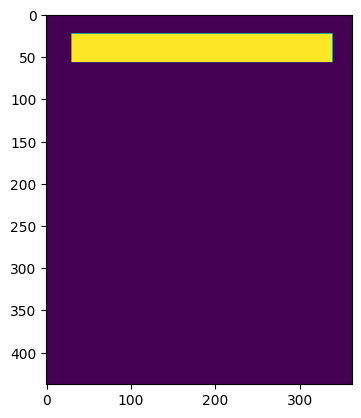

In [2500]:
bbox = detect_bbox(img_test)
print(bbox)
filter_and_reduce_bounding_boxes(bbox, img_test.shape[:2])

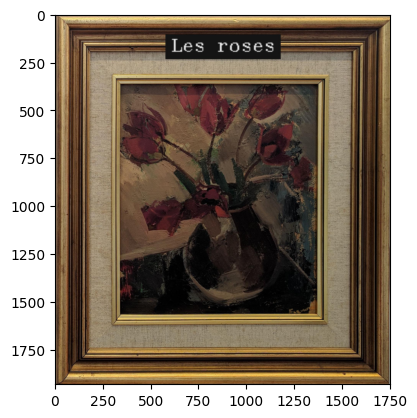

In [2455]:
plt.imshow(img_test)

In [2311]:
bboxes = (detect_bbox(img_test))
print(bboxes)
filter_and_reduce_bounding_boxes(bboxes, img_test.shape[:2])

[([474, 14, 24, 234], 5616, 9.75), ([0, 0, 28, 256], 7168, 9.142857142857142)]


[]

# A partir de aquí es el proceso de la función pero paso a paso para ir haciendo pruebas

In [2312]:
sub_a, sub_b = normalize(img_test[0:img_test.shape[0]//2,:,:]), normalize(img_test[img_test.shape[0]//2:,:,:])
print(sub_a.shape, sub_b.shape)

(283, 256, 3) (283, 256, 3)


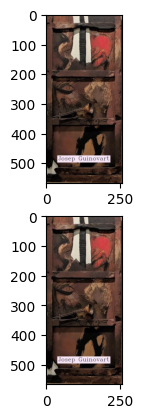

In [2313]:
f, axarr = plt.subplots(2,1)
axarr[0].imshow(img_test)
axarr[1].imshow(img_test, cmap="gray")


## Conver to other colorspace

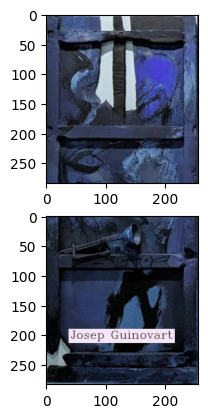

In [2314]:
lab_image_a = (cv2.cvtColor(sub_a, cv2.COLOR_BGR2RGB))
lab_image_b = (cv2.cvtColor(sub_b, cv2.COLOR_BGR2RGB))



# lab_image_a = normalize(sub_a)
# lab_image_b = normalize(sub_b)
f, axarr = plt.subplots(2,1)

axarr[0].imshow(lab_image_a)
axarr[1].imshow(lab_image_b)

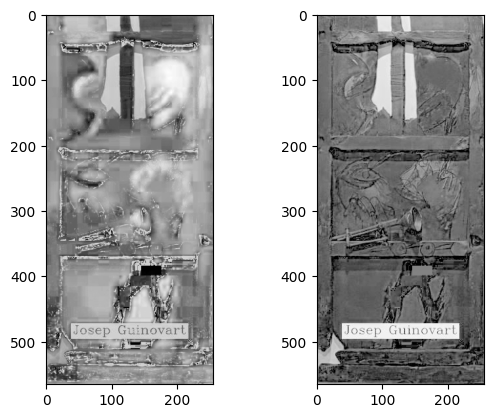

In [2315]:
hsv = cv2.cvtColor(img_test, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hsv)
lab = cv2.cvtColor(img_test, cv2.COLOR_RGB2LAB)
#s = cv2.GaussianBlur(s, (5, 5), 0)
l,a,b = cv2.split(lab)

l = normalize(l)

f, axarr = plt.subplots(1,2)

axarr[0].imshow(l+s, cmap="gray")
axarr[1].imshow(l-s, cmap="gray")


In [2316]:
image = l-s

In [2317]:
print(l-s)

[[ 0.7908972   0.43553522  0.33859017 ...  0.78207916  0.89084446
  -0.99738437]
 [ 0.6438986   0.2810899   0.22410032 ...  0.78605145  0.8151147
  -0.99487585]
 [ 0.5407547   0.17994079  0.17517146 ...  0.78207916  0.86080086
  -0.99738437]
 ...
 [ 0.36881697  0.24416125  0.10981417 ... -0.18715855  0.03497607
   0.39328188]
 [ 0.5803407   0.45744932  0.33838102 ... -0.040921    0.1771312
   0.3467192 ]
 [ 0.61026776  0.47462806  0.3511596  ... -0.9933495  -0.8718796
  -0.9073705 ]]


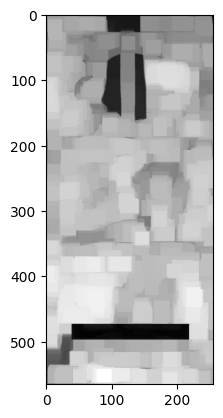

In [2318]:
morph_open = 1 - normalize(apply_closing(image, (20,20)))
plt.imshow(morph_open, cmap="gray")

In [2319]:
morph_open = conver2image(morph_open)

In [2320]:
mean = (np.mean(morph_open))
std = (np.std(morph_open))


print(mean)
print(std)


174.6674925463781
49.62556429440805


In [2321]:
print(morph_open)

[[ 37  37  52 ...  16  16  12]
 [ 37  37  52 ...  16  16  12]
 [ 65  65 130 ...  16  16  12]
 ...
 [ 82  82 138 ... 173 173 173]
 [ 82  82 138 ... 165 165 165]
 [ 78  78 102 ... 165 165 157]]


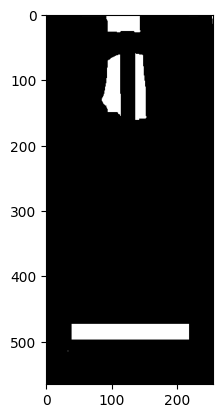

In [2322]:
ret, th1 = cv2.threshold(morph_open, np.min(morph_open)+((mean-std)*0.5),  255, cv2.THRESH_BINARY_INV)
#th = cv2.adaptiveThreshold(morph_open, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 3)
plt.imshow(th1, cmap="gray")

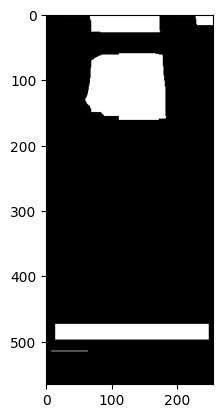

In [2323]:
th2 = apply_dilate(th1, (12,1))
plt.imshow(th2, cmap="gray")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


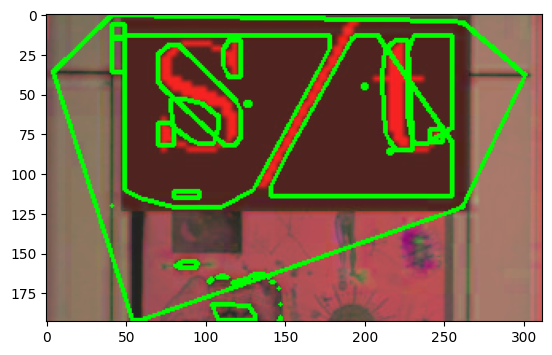

In [1003]:
contours, hierarchy = cv2.findContours(image_threshold, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
decission = []

for contour in contours:
    convexHull = cv2.convexHull(contour)

    perimeter = cv2.arcLength(convexHull, True)
    x,y,w,h = cv2.boundingRect(convexHull)
    aspect_ratio = w/h
    area = w*h
    #if (w>h) and (np.sqrt(aspect_ratio) <5):
    cv2.drawContours(lab_image_a, [convexHull], -1, (0, 255, 0), 2)
        

plt.imshow(lab_image_a)
            

## Paint Detection

In [4]:
BBDD =  sorted(utils.read_bbdd(Path("../data/qst2_w2")))
print(BBDD)

[PosixPath('../data/qst2_w2/00000.jpg'), PosixPath('../data/qst2_w2/00001.jpg'), PosixPath('../data/qst2_w2/00002.jpg'), PosixPath('../data/qst2_w2/00003.jpg'), PosixPath('../data/qst2_w2/00004.jpg'), PosixPath('../data/qst2_w2/00005.jpg'), PosixPath('../data/qst2_w2/00006.jpg'), PosixPath('../data/qst2_w2/00007.jpg'), PosixPath('../data/qst2_w2/00008.jpg'), PosixPath('../data/qst2_w2/00009.jpg'), PosixPath('../data/qst2_w2/00010.jpg'), PosixPath('../data/qst2_w2/00011.jpg'), PosixPath('../data/qst2_w2/00012.jpg'), PosixPath('../data/qst2_w2/00013.jpg'), PosixPath('../data/qst2_w2/00014.jpg'), PosixPath('../data/qst2_w2/00015.jpg'), PosixPath('../data/qst2_w2/00016.jpg'), PosixPath('../data/qst2_w2/00017.jpg'), PosixPath('../data/qst2_w2/00018.jpg'), PosixPath('../data/qst2_w2/00019.jpg'), PosixPath('../data/qst2_w2/00020.jpg'), PosixPath('../data/qst2_w2/00021.jpg'), PosixPath('../data/qst2_w2/00022.jpg'), PosixPath('../data/qst2_w2/00023.jpg'), PosixPath('../data/qst2_w2/00024.jpg'),

In [390]:
img_test = permute(utils.read_img(BBDD[18]))
img_test.shape

(912, 1245, 3)

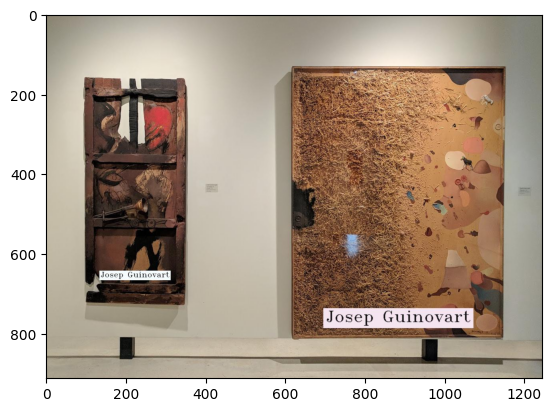

In [391]:
plt.imshow(img_test)

In [392]:
image = normalize(cv2.cvtColor(img_test, cv2.COLOR_RGB2Lab))

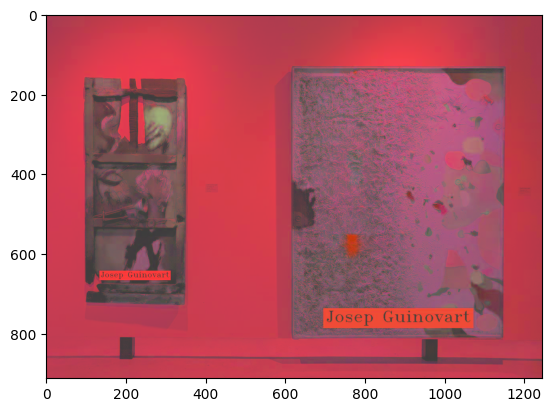

In [393]:
plt.imshow(image)

In [394]:
morph = apply_morpholical_grad(image, (7,7))
#closed = apply_open(morph, (7,7))

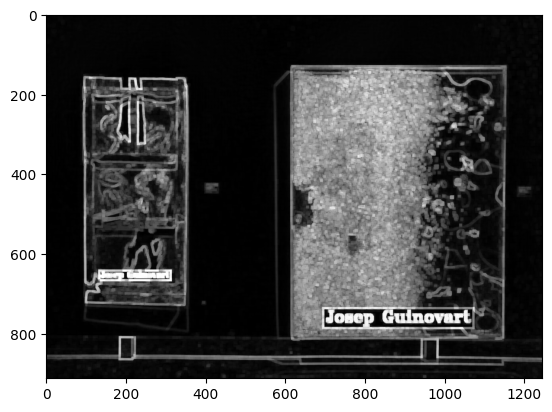

In [395]:
plt.imshow(((morph[:,:,0])), cmap="gray")

In [396]:
closed = (morph[:,:,0] * 255).astype(np.uint8)

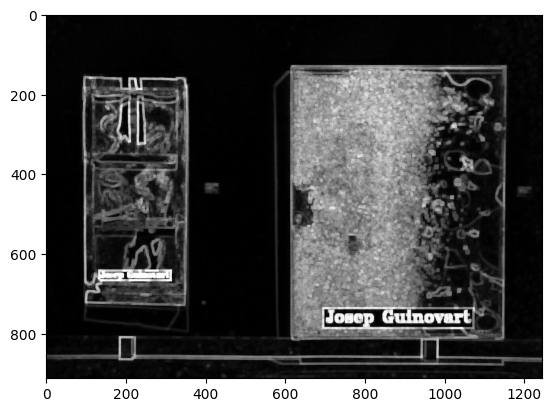

In [397]:
plt.imshow(closed,cmap="gray")

In [398]:
im = cv2.adaptiveThreshold(closed, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 3, 3)

In [399]:
im.shape

(912, 1245)

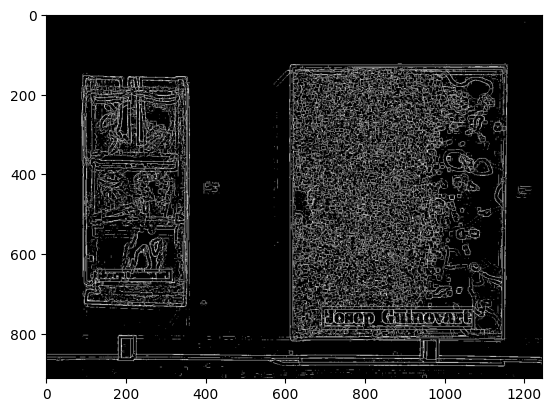

In [400]:
plt.imshow(im, cmap="gray")

In [401]:
tri = apply_closing(im, (3, 3))


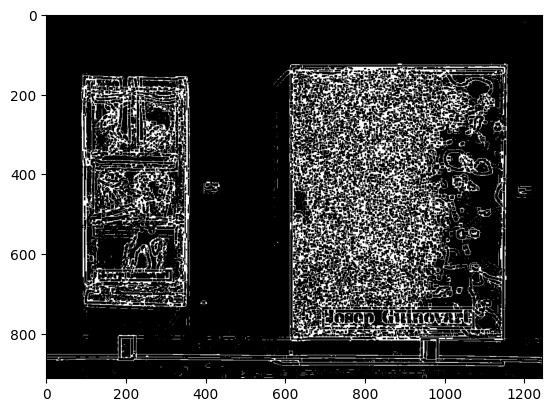

In [402]:
plt.imshow(tri, cmap="gray")

In [403]:
bb = get_roi_paintings(tri)
print(bb)
check_overlap([127, 105, 393, 474], [179, 182, 354, 404], threshold=0.5)

[([124, 0, 759, 1245], 3492.6461569070816, 944955, 1.640316205533597)]


True

In [271]:
def preproces_detect_bbox(image):

    # Prepare colorspaces
    print(image.shape)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(lab)
    l = normalize(l)

    image = l-s
    show_image(image)
    # Apply morphology
    morph_open = 1 - normalize(apply_closing(image, (20,20)))#1 - normalize(apply_dilate(image, (10,10)))
    show_image(morph_open)
    mean = (np.mean(morph_open))
    std = (np.std(morph_open)) 
    ret, th1 = cv2.threshold(morph_open, np.min(morph_open)+((mean-std)*0.5),  255, cv2.THRESH_BINARY_INV)
    th2 = apply_dilate(th1, (12,1))
    show_image(th2)
    
    return th2

def detect_bbox(image):
    ## Después del preproces la zona que tiene el texto esta oscurecido (por la saturación)
    ## así que  lo que quiero es coger la zona con una media más baja (más negro) para aplica el threshold
    ## Asumiendo que esa zona es muy negra (( errores ... imagenes con un fondo oscuro o muy saturado))
    
    th1 = preproces_detect_bbox(image)
    #plt.imshow(th1)
    contours, hierarchy = cv2.findContours(conver2image(th1), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    decission = []
    prop_low = 2*th1.shape[0]//5
    prop_upper = 4*th1.shape[0]//5
    for contour in contours:
        convexHull = cv2.convexHull(contour)
        
        x,y,w,h = cv2.boundingRect(convexHull)
        aspect_ratio = w/h
        area = w*h
        min_length  = w > th1.shape[1]*0.1
        relation_ar = np.sqrt(aspect_ratio)
        perimeter = cv2.arcLength(convexHull, True)
            
            
        if (h <= prop_low or (h >= prop_upper)) and ((relation_ar > 1) and (relation_ar < 6)) and (1.5*w>h) and (min_length): 
            decission.append(([y,x,h,w], area, perimeter ,aspect_ratio)) 

            
    decission = sorted(decission, key=lambda x: x[2], reverse=True)
            
            
    return decission 


def filter_and_reduce_bounding_boxes(bboxes, shape_mask):
    
    constrain_bbox = []
    processed_indexes = set()
    oh, ow = shape_mask
    for i in range(len(bboxes)):
        if i in processed_indexes:
            continue
            
        bbox1 = bboxes[i][0]
        y1, x1, h1, w1 = bbox1
        rec_ver1 = w1 > h1
        
        for j in range(i+1, len(bboxes)):
            if j in processed_indexes:
                continue
                
            y2,x2,h2,w2 = bboxes[j][0]
            y_overlap = abs(y1 - y2)
            rec_ver2 = w2 > h2
            
            if (y_overlap <= (oh*0.05)) and (rec_ver1 and rec_ver2):
                y, x = min([y1,x1], [y2, x2], key=lambda x: x[1])
                w = w1 + w2
                h = max(h1, h2)
                area = w*h
                try:
                    aspect_ratio = w/h
                except:
                    aspect_ratio = 0
                constrain_bbox.append(([y,x,h,w], area, aspect_ratio))
                
                processed_indexes.add(j)        
                
    return constrain_bbox

def detect_text(image:np.ndarray):
    mask = np.zeros((im.shape[:2]))
    bbox = detect_bbox(image)
    print(bbox)
    
def check_overlap(ba, bb, threshold:float=0.5):
    
    y1, x1, h1, w1 = ba
    y2, x2, h2, w2 = bb
    
    
    # Calculate the coordinates of the bounding boxes
    x1_min, y1_min, x1_max, y1_max = x1, y1, x1 + w1, y1 + h1
    x2_min, y2_min, x2_max, y2_max = x2, y2, x2 + w2, y2 + h2
    

    # Calculate the intersection area
    intersection_area = max(0, min(x1_max, x2_max) - max(x1_min, x2_min)) * \
                        max(0, min(y1_max, y2_max) - max(y1_min, y2_min))
    
    
        # Calculate areas of each bounding box
    area_bbox1 = (x1_max - x1_min) * (y1_max - y1_min)
    area_bbox2 = (x2_max - x2_min) * (y2_max - y2_min)
    
        # Calculate areas of each bounding box
    area_bbox1 = w1 * h1
    area_bbox2 = w2 * h2

    
    overlap_ratio = intersection_area / min(area_bbox1, area_bbox2)
    return overlap_ratio >= threshold



    

def create_bbox_masks(images: List[Image]):
    result = {image.name:{} for image in images}
    
    for idx, image in enumerate(images):
        im = permute(utils.read_img(image))
        mask = np.zeros((im.shape[:2]))

        bboxes = detect_bbox(im)
        #print(bboxes)
        if len(bboxes) == 1:
            y,x,h,w = bboxes[0][0]

        else:
            reduction = filter_and_reduce_bounding_boxes(bboxes, mask.shape)
            tmp = reduction
            print(tmp)
            while (len(reduction)) != 0:
                reduction = filter_and_reduce_bounding_boxes(tmp, mask.shape)
                print(reduction)
                if len(reduction) != 0:
                    tmp = reduction

            else:
                if len(tmp) == 0:
                    tmp = bboxes

            print(tmp, image.name)

            bboxes = sorted(tmp, key=lambda x: x[2], reverse=True)[0]  
            y, x, h, w = bboxes[0]

        # [[tlx1, tly1, brx1, bry1],[tlx2, tly2, brx2, bry2]]

        mask[y:y+h, x:x+w] = 1
        result[image.name]["mask"] = mask
        result[image.name]["bbox"] = [[x,y, x+w, y+h]]
        #plt.imshow(mask, cmap="gray")

    return result
            
                
            
                
            
            
            
 

In [381]:
def get_roi_paintings(image:np.ndarray):
    
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    decission = []
    heigh_im, width_im = image.shape
    
    area_total = heigh_im * width_im

    for contour in contours:
        convexHull = cv2.convexHull(contour)
        
        perimeter = cv2.arcLength(convexHull, True)
        x,y,w,h = cv2.boundingRect(convexHull)
        aspect_ratio = w/h
        area = w*h
        proportion_height =  h/heigh_im
        proportion_width = w / width_im
        
        if (proportion_height > 0.1) and (proportion_width > 0.1) :
            decission.append(([y,x,h,w], perimeter, area ,aspect_ratio))
    
    decission = sorted(decission, key=lambda x: x[2], reverse=True)
    final_voting = [decission[0]]
    
    for i in (decission[1:]):
        if check_overlap(decission[0][0], i[0], threshold=0.6) is not True:
            final_voting.append(i)
            
        
    return final_voting

def extract_paintings(imgs: List[np.ndarray]):
    
    """
    We assume that the image is in CieLab or CieLuv
    """
    response = {idx:[] for idx in range(len(imgs))}
    for idx, img in enumerate(imgs):
        im = permute(utils.read_img(img))
        im = normalize(cv2.cvtColor(im, cv2.COLOR_RGB2Lab))     
        morph = apply_morpholical_grad(im, (7,7))
        luminance = (morph[:,:,0]*255).astype(np.uint8)
        thresholded = cv2.adaptiveThreshold(luminance, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 3, 3)
        final_image = apply_closing(thresholded, (3,3))
        #final_image = apply_dilate(final_image, (3,3))
        
        decission = get_roi_paintings(final_image)
        
        
        for dec in decission:
            y,x,h,w = dec[0]
            cropped = final_image[y:y+h, x:x+w]
            response[idx].append([y,x,h,w])
            
    return response

In [382]:
print(BBDD)

[PosixPath('../data/qst2_w2/00000.jpg'), PosixPath('../data/qst2_w2/00001.jpg'), PosixPath('../data/qst2_w2/00002.jpg'), PosixPath('../data/qst2_w2/00003.jpg'), PosixPath('../data/qst2_w2/00004.jpg'), PosixPath('../data/qst2_w2/00005.jpg'), PosixPath('../data/qst2_w2/00006.jpg'), PosixPath('../data/qst2_w2/00007.jpg'), PosixPath('../data/qst2_w2/00008.jpg'), PosixPath('../data/qst2_w2/00009.jpg'), PosixPath('../data/qst2_w2/00010.jpg'), PosixPath('../data/qst2_w2/00011.jpg'), PosixPath('../data/qst2_w2/00012.jpg'), PosixPath('../data/qst2_w2/00013.jpg'), PosixPath('../data/qst2_w2/00014.jpg'), PosixPath('../data/qst2_w2/00015.jpg'), PosixPath('../data/qst2_w2/00016.jpg'), PosixPath('../data/qst2_w2/00017.jpg'), PosixPath('../data/qst2_w2/00018.jpg'), PosixPath('../data/qst2_w2/00019.jpg'), PosixPath('../data/qst2_w2/00020.jpg'), PosixPath('../data/qst2_w2/00021.jpg'), PosixPath('../data/qst2_w2/00022.jpg'), PosixPath('../data/qst2_w2/00023.jpg'), PosixPath('../data/qst2_w2/00024.jpg'),

In [383]:
descriptors_bdr, _ = utils.get_descriptor_database("../data/BBDD/descriptors/qsd1_w2_multiresolution_histint.pkl")
print(descriptors_bdr["bbdd_00000.jpg"].shape)

(5184,)


In [384]:
response = extract_paintings(BBDD)

In [385]:
response

{0: [[89, 561, 551, 683], [175, 71, 285, 228]],
 1: [[111, 204, 2086, 1675]],
 2: [[83, 94, 863, 647]],
 3: [[82, 88, 1955, 1721]],
 4: [[121, 123, 2062, 1470]],
 5: [[56, 2223, 1455, 1737],
  [84, 539, 1177, 1297],
  [85, 132, 1429, 1041],
  [487, 302, 1001, 1403],
  [315, 358, 1027, 803],
  [449, 724, 392, 794],
  [1321, 693, 209, 1147],
  [1235, 1345, 213, 442]],
 6: [[85, 97, 600, 453]],
 7: [[78, 71, 535, 564]],
 8: [[72, 508, 356, 272], [92, 94, 305, 246]],
 9: [[141, 1804, 2031, 1660],
  [72, 136, 1211, 1447],
  [1404, 291, 871, 876],
  [2073, 190, 307, 1391]],
 10: [[52, 64, 1677, 1477],
  [578, 2677, 698, 818],
  [562, 2751, 637, 711],
  [742, 3019, 512, 427]],
 11: [[82, 55, 600, 622]],
 12: [[103, 68, 344, 297]],
 13: [[122, 60, 522, 522]],
 14: [[75, 58, 675, 530]],
 15: [[0, 110, 744, 921], [0, 1284, 677, 758]],
 16: [[61, 84, 1872, 1528]],
 17: [[57, 57, 555, 405]],
 18: [[124, 0, 759, 1245]],
 19: [[73, 77, 584, 444]],
 20: [[81, 107, 1049, 1265]],
 21: [[134, 644, 302, 

In [386]:
from metrics.retrieval_distances import *


In [387]:
final_retireval = []
for idx, masks in response.items():
    #print(masks)
    image_to_proces =  permute(utils.read_img(BBDD[idx]))
    #show_image(image_to_proces)
    buffer_to_retriev = []
    included_bboxes = masks[:2]

    if len(masks) == 1:
        y,x,h,w = masks[0]
        image = image_to_proces[y:y+h, x:x+w,:]
        image =  normalize(cv2.cvtColor(image, cv2.COLOR_RGB2LAB))
        feature_compare = CD.get_multi_tile_histogram_descriptor(image, tiles=6)
        scoring_list = utils.retriev_image(descriptors_bdr, feature_compare, distance=histogram_intersection)
        buffer_to_retriev.append([ind[1] for ind in scoring_list[:10]])

    else:
#         #print(masks)
#         print(masks)
#         if check_overlap(included_bboxes[0], included_bboxes[1]) is True:
#             masks = [masks[0]]
            
#         else:
#             masks = included_bboxes
        #print(masks)
        
        for bbox in masks[:2]:
            print(idx,bbox)
            y,x,h,w = bbox
            image = image_to_proces[y:y+h, x:x+w,:]
            image =  normalize(cv2.cvtColor(image, cv2.COLOR_RGB2LAB))
            feature_compare = CD.get_multi_tile_histogram_descriptor(image, tiles=6)
            scoring_list = utils.retriev_image(descriptors_bdr, feature_compare, distance=histogram_intersection)
            buffer_to_retriev.append([ind[1] for ind in scoring_list[:10]])

    
    final_retireval.append(buffer_to_retriev)


print(final_retireval)

0 [89, 561, 551, 683]
0 [175, 71, 285, 228]
5 [56, 2223, 1455, 1737]
5 [84, 539, 1177, 1297]
8 [72, 508, 356, 272]
8 [92, 94, 305, 246]
9 [141, 1804, 2031, 1660]
9 [72, 136, 1211, 1447]
10 [52, 64, 1677, 1477]
10 [578, 2677, 698, 818]
15 [0, 110, 744, 921]
15 [0, 1284, 677, 758]
21 [134, 644, 302, 342]
21 [169, 65, 210, 431]
28 [138, 748, 461, 669]
28 [173, 98, 361, 461]
[[[27, 32, 130, 246, 230, 219, 148, 179, 259, 188], [270, 52, 12, 226, 240, 191, 165, 108, 254, 152]], [[130, 202, 132, 197, 8, 63, 162, 160, 192, 84]], [[197, 120, 26, 47, 206, 8, 130, 184, 162, 160]], [[179, 219, 160, 10, 264, 188, 230, 286, 213, 186]], [[260, 162, 197, 21, 166, 26, 51, 141, 47, 8]], [[248, 150, 166, 23, 154, 260, 31, 59, 266, 95], [262, 215, 135, 23, 223, 26, 192, 29, 123, 154]], [[136, 249, 55, 122, 76, 167, 70, 140, 119, 181]], [[166, 23, 132, 266, 260, 59, 200, 93, 69, 192]], [[184, 182, 194, 34, 8, 148, 186, 264, 9, 188], [49, 65, 153, 179, 219, 279, 274, 230, 18, 264]], [[29, 163, 23, 69, 88, 1

In [388]:
print(final_retireval)

[[[27, 32, 130, 246, 230, 219, 148, 179, 259, 188], [270, 52, 12, 226, 240, 191, 165, 108, 254, 152]], [[130, 202, 132, 197, 8, 63, 162, 160, 192, 84]], [[197, 120, 26, 47, 206, 8, 130, 184, 162, 160]], [[179, 219, 160, 10, 264, 188, 230, 286, 213, 186]], [[260, 162, 197, 21, 166, 26, 51, 141, 47, 8]], [[248, 150, 166, 23, 154, 260, 31, 59, 266, 95], [262, 215, 135, 23, 223, 26, 192, 29, 123, 154]], [[136, 249, 55, 122, 76, 167, 70, 140, 119, 181]], [[166, 23, 132, 266, 260, 59, 200, 93, 69, 192]], [[184, 182, 194, 34, 8, 148, 186, 264, 9, 188], [49, 65, 153, 179, 219, 279, 274, 230, 18, 264]], [[29, 163, 23, 69, 88, 193, 14, 135, 215, 39], [113, 161, 205, 168, 163, 94, 137, 40, 103, 244]], [[26, 277, 272, 283, 47, 28, 141, 206, 23, 260], [44, 275, 23, 166, 28, 63, 285, 26, 215, 4]], [[219, 179, 264, 230, 153, 10, 34, 254, 9, 65]], [[64, 278, 79, 266, 271, 78, 93, 150, 133, 59]], [[273, 133, 224, 126, 278, 64, 6, 271, 17, 168]], [[12, 230, 32, 27, 153, 156, 219, 264, 148, 10]], [[162, 

In [389]:
for idx,i in enumerate(final_retireval):
    print(len(i), "idx", idx)

2 idx 0
1 idx 1
1 idx 2
1 idx 3
1 idx 4
2 idx 5
1 idx 6
1 idx 7
2 idx 8
2 idx 9
2 idx 10
1 idx 11
1 idx 12
1 idx 13
1 idx 14
2 idx 15
1 idx 16
1 idx 17
1 idx 18
1 idx 19
1 idx 20
2 idx 21
1 idx 22
1 idx 23
1 idx 24
1 idx 25
1 idx 26
1 idx 27
2 idx 28
1 idx 29


In [404]:
for i in final_retireval:
    if len(i) == 1:
        i.append([])

In [406]:
for idx,i in enumerate(final_retireval):
    print(len(i), "idx", idx)

2 idx 0
2 idx 1
2 idx 2
2 idx 3
2 idx 4
2 idx 5
2 idx 6
2 idx 7
2 idx 8
2 idx 9
2 idx 10
2 idx 11
2 idx 12
2 idx 13
2 idx 14
2 idx 15
2 idx 16
2 idx 17
2 idx 18
2 idx 19
2 idx 20
2 idx 21
2 idx 22
2 idx 23
2 idx 24
2 idx 25
2 idx 26
2 idx 27
2 idx 28
2 idx 29


In [407]:
utils.write_pickle(final_retireval, filepath="./results.pkl")